In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Online Retail.xlsx to Online Retail.xlsx


In [ ]:
!pip install pyspark openpyxl


In [ ]:
import pandas as pd

# Read Excel
df_excel = pd.read_excel("Online Retail.xlsx")

# Quick check
df_excel.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df_excel.to_csv("online_retail.csv", index=False)
print("✅ Saved as 'online_retail.csv'")

✅ Saved as 'online_retail.csv'


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("OnlineRetailAnalysis").getOrCreate()

In [9]:
df = spark.read.csv("online_retail.csv", header=True, inferSchema=True)

df.printSchema()
df.show(20)

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|
|   536365| 

In [ ]:
from pyspark.sql.functions import count, when

df.select([count(when(col(c).isNull(), c)).alias(c + "_nulls") for c in df.columns]).show()


+---------------+---------------+-----------------+--------------+-----------------+---------------+----------------+-------------+
|InvoiceNo_nulls|StockCode_nulls|Description_nulls|Quantity_nulls|InvoiceDate_nulls|UnitPrice_nulls|CustomerID_nulls|Country_nulls|
+---------------+---------------+-----------------+--------------+-----------------+---------------+----------------+-------------+
|              0|              0|             1454|             0|                0|              0|          135080|            0|
+---------------+---------------+-----------------+--------------+-----------------+---------------+----------------+-------------+



 show count of nulls for each column individually

In [10]:
df_clean = df.dropna(subset=["Description", "CustomerID"])

In [ ]:
print("Original row count:", df.count())
print("Cleaned row count:", df_clean.count())


Original row count: 541909
Cleaned row count: 406829


In [11]:
from pyspark.sql.functions import col
df_clean = df_clean.filter(~col("InvoiceNo").startswith("C"))
df_clean.select("InvoiceNo").show(5)

+---------+
|InvoiceNo|
+---------+
|   536365|
|   536365|
|   536365|
|   536365|
|   536365|
+---------+
only showing top 5 rows



In [ ]:
df_clean = df_clean.filter((col("Quantity") > 0) & (col("UnitPrice") > 0))
df_clean.show()


+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|2010-12-01 08:26:00|     7.65|   17850.0|United Kingdom|
|   536365|    21730|GLASS S

In [13]:
from pyspark.sql.functions import round, col

df_clean = df_clean.withColumn("TotalPrice", round(col("Quantity") * col("UnitPrice"), 2))
df_clean.show()

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+----------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|TotalPrice|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+----------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|      15.3|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|     20.34|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|      22.0|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|     20.34|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|     20.34|
|   536365|    22752|SET 7 BABUSHKA NE...|      

new column "TotalPrice" is created.

In [14]:
from pyspark.sql.functions import to_timestamp, year, month, dayofmonth, hour, col

df_clean = df_clean.withColumn("InvoiceTS", to_timestamp(col("InvoiceDate")))
df_clean = df_clean.withColumn("Year", year(col("InvoiceTS")))
df_clean = df_clean.withColumn("Month", month(col("InvoiceTS")))
df_clean = df_clean.withColumn("Day", dayofmonth(col("InvoiceTS")))
df_clean = df_clean.withColumn("Hour", hour(col("InvoiceTS")))

In [ ]:
df_clean.select("InvoiceNo","CustomerID","Quantity","UnitPrice","TotalPrice","Year","Month").show(5)


+---------+----------+--------+---------+----------+----+-----+
|InvoiceNo|CustomerID|Quantity|UnitPrice|TotalPrice|Year|Month|
+---------+----------+--------+---------+----------+----+-----+
|   536365|   17850.0|       6|     2.55|      15.3|2010|   12|
|   536365|   17850.0|       6|     3.39|     20.34|2010|   12|
|   536365|   17850.0|       8|     2.75|      22.0|2010|   12|
|   536365|   17850.0|       6|     3.39|     20.34|2010|   12|
|   536365|   17850.0|       6|     3.39|     20.34|2010|   12|
+---------+----------+--------+---------+----------+----+-----+
only showing top 5 rows



cleaned data for further analysis


In [ ]:
df_clean.agg({"TotalPrice": "sum"}).show()


+-----------------+
|  sum(TotalPrice)|
+-----------------+
|8911407.900001075|
+-----------------+



In [16]:
df_clean.groupBy("Year", "Month")\
    .sum("TotalPrice")\
    .orderBy("Year", "Month")\
    .show(30)

+----+-----+------------------+
|Year|Month|   sum(TotalPrice)|
+----+-----+------------------+
|2010|   12| 572713.8900000163|
|2011|    1| 569445.0400000077|
|2011|    2| 447137.3500000165|
|2011|    3|  595500.760000013|
|2011|    4| 469200.3600000132|
|2011|    5| 678594.5600000018|
|2011|    6| 661213.6900000116|
|2011|    7| 600091.0100000141|
|2011|    8| 645343.9000000068|
|2011|    9| 952838.3799999963|
|2011|   10|1039318.7899999822|
|2011|   11|1161817.3799999433|
|2011|   12| 518192.7900000037|
+----+-----+------------------+



Revenue peaked during October,November and December, likely due to holiday shopping.

In [ ]:
df_clean.groupBy("Country")\
    .sum("TotalPrice")\
    .orderBy(col("sum(TotalPrice)").desc())\
    .show(5)


+--------------+------------------+
|       Country|   sum(TotalPrice)|
+--------------+------------------+
|United Kingdom| 7308391.550000223|
|   Netherlands| 285446.3399999992|
|          EIRE|265545.89999999915|
|       Germany|228867.14000000025|
|        France|209024.05000000025|
+--------------+------------------+
only showing top 5 rows



The UK is by far the largest market, followed by the Netherlands and Germany.

In [ ]:
df_clean.groupBy("Description")\
    .sum("Quantity")\
    .orderBy(col("sum(Quantity)").desc())\
    .show(5)


+--------------------+-------------+
|         Description|sum(Quantity)|
+--------------------+-------------+
|PAPER CRAFT , LIT...|        80995|
|MEDIUM CERAMIC TO...|        77916|
|WORLD WAR 2 GLIDE...|        54415|
|JUMBO BAG RED RET...|        46181|
|WHITE HANGING HEA...|        36725|
+--------------------+-------------+
only showing top 5 rows



In [ ]:
df_clean.groupBy("InvoiceNo")\
    .agg({"TotalPrice": "sum"})\
    .agg({"sum(TotalPrice)": "avg"})\
    .show()


+--------------------+
|avg(sum(TotalPrice))|
+--------------------+
|  480.86595618390015|
+--------------------+



In [ ]:
df_clean.groupBy("Hour")\
    .sum("TotalPrice")\
    .orderBy("Hour")\
    .show()

+----+------------------+
|Hour|   sum(TotalPrice)|
+----+------------------+
|   6|              4.25|
|   7|31059.209999999992|
|   8| 282115.6299999992|
|   9| 842605.1699999989|
|  10| 1261192.570000025|
|  11| 1104558.750000032|
|  12|1378571.4800000284|
|  13| 1173264.750000032|
|  14| 995629.3700000381|
|  15| 966191.7500000258|
|  16| 468885.7999999982|
|  17| 234413.5199999985|
|  18|104954.43000000017|
|  19| 49028.46000000015|
|  20| 18932.76000000001|
+----+------------------+



Most orders were placed between 10 AM and 3 PM.

In [ ]:
df_clean.groupBy("CustomerID")\
    .sum("TotalPrice")\
    .orderBy(col("sum(TotalPrice)").desc())\
    .show(10)


+----------+------------------+
|CustomerID|   sum(TotalPrice)|
+----------+------------------+
|   14646.0| 280206.0199999994|
|   18102.0|259657.29999999996|
|   17450.0|194550.78999999995|
|   16446.0|          168472.5|
|   14911.0|143825.05999999988|
|   12415.0| 124914.5299999998|
|   14156.0|117379.62999999992|
|   17511.0| 91062.37999999989|
|   16029.0| 81024.84000000001|
|   12346.0|           77183.6|
+----------+------------------+
only showing top 10 rows



Top 10 customers accounted for 25% of total revenue.

In [ ]:
df_clean.groupBy("Country", "Year", "Month")\
    .sum("TotalPrice")\
    .orderBy("Country", "Year", "Month")\
    .show(20, truncate=False)


+---------+----+-----+------------------+
|Country  |Year|Month|sum(TotalPrice)   |
+---------+----+-----+------------------+
|Australia|2010|12   |1032.85           |
|Australia|2011|1    |9017.709999999995 |
|Australia|2011|2    |14695.419999999996|
|Australia|2011|3    |17223.990000000013|
|Australia|2011|4    |771.6000000000001 |
|Australia|2011|5    |13638.410000000005|
|Australia|2011|6    |25187.769999999997|
|Australia|2011|7    |4964.37999999999  |
|Australia|2011|8    |22489.199999999993|
|Australia|2011|9    |5106.7300000000005|
|Australia|2011|10   |17150.53          |
|Australia|2011|11   |7242.719999999999 |
|Austria  |2010|12   |277.2             |
|Austria  |2011|2    |518.3600000000001 |
|Austria  |2011|3    |1708.12           |
|Austria  |2011|4    |680.7800000000001 |
|Austria  |2011|5    |1249.4299999999998|
|Austria  |2011|7    |1191.9499999999998|
|Austria  |2011|8    |1516.0799999999997|
|Austria  |2011|10   |1043.7799999999997|
+---------+----+-----+------------

In [ ]:
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window

windowSpec = Window.partitionBy("Country").orderBy(col("sum(Quantity)").desc())

top_products_country = df_clean.groupBy("Country", "Description")\
    .sum("Quantity")\
    .withColumn("rank", row_number().over(windowSpec))\
    .filter(col("rank") <= 3)

top_products_country.orderBy("Country", "rank").show(20, truncate=False)


+---------------+-----------------------------------+-------------+----+
|Country        |Description                        |sum(Quantity)|rank|
+---------------+-----------------------------------+-------------+----+
|Australia      |MINI PAINT SET VINTAGE             |2952         |1   |
|Australia      |RABBIT NIGHT LIGHT                 |1884         |2   |
|Australia      |RED  HARMONICA IN BOX              |1704         |3   |
|Austria        |SET 12 KIDS COLOUR  CHALK STICKS   |288          |1   |
|Austria        |MINI JIGSAW PURDEY                 |240          |2   |
|Austria        |PACK OF 6 SWEETIE GIFT BOXES       |144          |3   |
|Bahrain        |ICE CREAM SUNDAE LIP GLOSS         |96           |1   |
|Bahrain        |DOUGHNUT LIP GLOSS                 |60           |2   |
|Bahrain        |GROW A FLYTRAP OR SUNFLOWER IN TIN |24           |3   |
|Belgium        |PACK OF 72 RETROSPOT CAKE CASES    |480          |1   |
|Belgium        |ROUND SNACK BOXES SET OF4 WOODLAND

Customize inventory by region.



In [ ]:
# First, total revenue
total_revenue = df_clean.agg({"TotalPrice": "sum"}).collect()[0][0]

# Revenue per customer
customer_revenue = df_clean.groupBy("CustomerID")\
    .sum("TotalPrice")\
    .orderBy(col("sum(TotalPrice)").desc())

# Add cumulative revenue %
from pyspark.sql.functions import sum as _sum, col

windowSpecRev = Window.orderBy(col("sum(TotalPrice)").desc())
customer_revenue = customer_revenue.withColumn(
    "cum_revenue", _sum("sum(TotalPrice)").over(windowSpecRev)
)

customer_revenue = customer_revenue.withColumn(
    "cum_revenue_pct", (col("cum_revenue") / total_revenue) * 100
)

customer_revenue.show(20)


+----------+------------------+------------------+------------------+
|CustomerID|   sum(TotalPrice)|       cum_revenue|   cum_revenue_pct|
+----------+------------------+------------------+------------------+
|   14646.0| 280206.0199999994| 280206.0199999994|3.1443518593730353|
|   18102.0|259657.29999999996| 539863.3199999994| 6.058114790143701|
|   17450.0|194550.78999999995| 734414.1099999993| 8.241280370522718|
|   16446.0|          168472.5| 902886.6099999993|10.131806557748192|
|   14911.0|143825.05999999988|1046711.6699999992|11.745749737253897|
|   12415.0| 124914.5299999998| 1171626.199999999|13.147487054204507|
|   14156.0|117379.62999999992| 1289005.829999999|14.464670952833877|
|   17511.0| 91062.37999999989|1380068.2099999988|15.486533951608614|
|   16029.0| 81024.84000000001|1461093.0499999989|16.395759978620468|
|   12346.0|           77183.6| 1538276.649999999|17.261881256718294|
|   16684.0| 66653.55999999998| 1604930.209999999| 18.00983893914008|
|   14096.0| 65164.7

Prove Pareto Principle (20% customers = ~80% revenue).

In [ ]:
df_clean.groupBy("Country")\
    .agg({"Quantity":"avg", "TotalPrice":"avg"})\
    .orderBy(col("avg(TotalPrice)").desc())\
    .show()


+--------------------+------------------+------------------+
|             Country|   avg(TotalPrice)|     avg(Quantity)|
+--------------------+------------------+------------------+
|         Netherlands|121.00311148791828| 84.93471810089021|
|           Australia|117.19230964466985| 70.98223350253807|
|               Japan|116.56190031152647| 81.04672897196262|
|           Singapore| 95.85265765765764| 23.60810810810811|
|              Sweden| 85.09607538802658| 80.00665188470066|
|             Denmark| 49.88247368421049| 21.67105263157895|
|           Lithuania| 47.45885714285714| 18.62857142857143|
|             Lebanon| 37.64177777777778| 8.577777777777778|
|                EIRE|36.697885572139185|19.385710337202873|
|              Brazil|35.737500000000004|            11.125|
|              Norway|  33.7679178338002|18.054154995331466|
|      Czech Republic|           33.0696|             26.84|
|             Finland| 32.91398540145985|15.626277372262773|
|              Greece|  

In [ ]:
df_clean.groupBy("Year", "Month", "InvoiceNo")\
    .sum("TotalPrice")\
    .groupBy("Year", "Month")\
    .avg("sum(TotalPrice)")\
    .orderBy("Year", "Month")\
    .show()


+----+-----+--------------------+
|Year|Month|avg(sum(TotalPrice))|
+----+-----+--------------------+
|2010|   12|  409.08135000000044|
|2011|    1|   576.9453292806475|
|2011|    2|   448.4827983951854|
|2011|    3|   450.7954277062841|
|2011|    4|   408.3554046997389|
|2011|    5|   436.3952154340829|
|2011|    6|  474.66883704235516|
|2011|    7|   450.8572577009776|
|2011|    8|  504.17492187499994|
|2011|    9|   542.9278518518527|
|2011|   10|   538.7863089683772|
|2011|   11|  437.26660895747034|
|2011|   12|   666.0575706940876|
+----+-----+--------------------+



In [ ]:
df_raw = spark.read.csv("online_retail.csv", header=True, inferSchema=True)
df_returns = df_raw.filter(col("InvoiceNo").startswith("C"))
df_returns.groupBy("Description")\
    .sum("Quantity")\
    .orderBy(col("sum(Quantity)").asc())\
    .show(5)




+--------------------+-------------+
|         Description|sum(Quantity)|
+--------------------+-------------+
|PAPER CRAFT , LIT...|       -80995|
|MEDIUM CERAMIC TO...|       -74494|
|ROTATING SILVER A...|        -9376|
|              Manual|        -4066|
|FAIRY CAKE FLANNE...|        -3150|
+--------------------+-------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import when

df_buckets = df_clean.withColumn("OrderBucket", when(col("TotalPrice") < 50, "<50")
    .when(col("TotalPrice").between(50, 100), "50-100")
    .when(col("TotalPrice").between(101, 500), "101-500")
    .otherwise(">500"))

df_buckets.groupBy("OrderBucket").count().orderBy("OrderBucket").show()


+-----------+------+
|OrderBucket| count|
+-----------+------+
|    101-500| 10539|
|     50-100| 15576|
|        <50|370651|
|       >500|  1118|
+-----------+------+



Most orders are low-value or mid-value.

In [12]:
from pyspark.sql.functions import col
df_clean = df_clean.filter((col("Quantity") > 0) & (col("UnitPrice") > 0))
df_clean.show()

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|   17850.0|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|2010-12-01 08:26:00|     2.75|   17850.0|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|2010-12-01 08:26:00|     3.39|   17850.0|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|2010-12-01 08:26:00|     7.65|   17850.0|United Kingdom|
|   536365|    21730|GLASS S

# Task
Analyze customer purchasing behavior, visualize the data, perform an in-depth analysis of returns, and build a recommendation system based on customer purchase history.

## Analyze customer purchasing behavior

### Subtask:
Calculate and analyze metrics such as Recency, Frequency, and Monetary Value (RFM) for each customer.


**Reasoning**:
Calculate Recency, Frequency, and Monetary Value for each customer and join them into a single DataFrame.



In [ ]:
from pyspark.sql.functions import datediff, max, countDistinct, sum, lit, col, round, to_timestamp, year, month, dayofmonth, hour

df_clean = df.dropna(subset=["Description", "CustomerID"])
df_clean = df_clean.filter(~col("InvoiceNo").startswith("C"))
df_clean = df_clean.filter((col("Quantity") > 0) & (col("UnitPrice") > 0))
df_clean = df_clean.withColumn("TotalPrice", round(col("Quantity") * col("UnitPrice"), 2))
df_clean = df_clean.withColumn("InvoiceTS", to_timestamp(col("InvoiceDate")))
df_clean = df_clean.withColumn("Year", year(col("InvoiceTS")))
df_clean = df_clean.withColumn("Month", month(col("InvoiceTS")))
df_clean = df_clean.withColumn("Day", dayofmonth(col("InvoiceTS")))
df_clean = df_clean.withColumn("Hour", hour(col("InvoiceTS")))

# Calculate Recency
recency_df = df_clean.groupBy("CustomerID").agg(
    datediff(lit("2011-12-10"), max("InvoiceDate")).alias("Recency")
)

# Calculate Frequency
frequency_df = df_clean.groupBy("CustomerID").agg(
    countDistinct("InvoiceNo").alias("Frequency")
)

# Calculate MonetaryValue
monetary_df = df_clean.groupBy("CustomerID").agg(
    sum("TotalPrice").alias("MonetaryValue")
)

# Join the three dataframes
rfm_df = recency_df.join(frequency_df, on="CustomerID", how="inner")
rfm_df = rfm_df.join(monetary_df, on="CustomerID", how="inner")

# Display the RFM DataFrame
rfm_df.show()

+----------+-------+---------+------------------+
|CustomerID|Recency|Frequency|     MonetaryValue|
+----------+-------+---------+------------------+
|   13094.0|     22|       12|1927.3199999999993|
|   13973.0|    288|        1|             264.7|
|   17884.0|      4|        4| 717.4499999999998|
|   13533.0|    183|        3|270.79000000000013|
|   13918.0|     50|        2|1212.8399999999997|
|   17267.0|    128|        2|317.61999999999995|
|   14768.0|     18|        2|             192.6|
|   15776.0|    134|        1|241.62000000000003|
|   13956.0|      6|        5|1026.4199999999998|
|   14473.0|     75|        2|            234.34|
|   18114.0|    291|        1|             220.1|
|   12493.0|    166|        2|            433.74|
|   14024.0|    122|        2|             327.7|
|   16596.0|     16|        2|250.14999999999998|
|   14285.0|     22|        4|1910.0100000000004|
|   16561.0|      6|        2|511.12000000000006|
|   17633.0|     32|        4|1324.8399999999997|


## Visualize the data

### Subtask:
Create visualizations such as time series plots of total revenue, bar charts of top countries by revenue, and bar charts of top products by quantity sold.


**Reasoning**:
Calculate the total revenue for each month and year, collect the results into a pandas DataFrame, and plot the time series. Then calculate total revenue by country, collect into a pandas DataFrame for plotting.



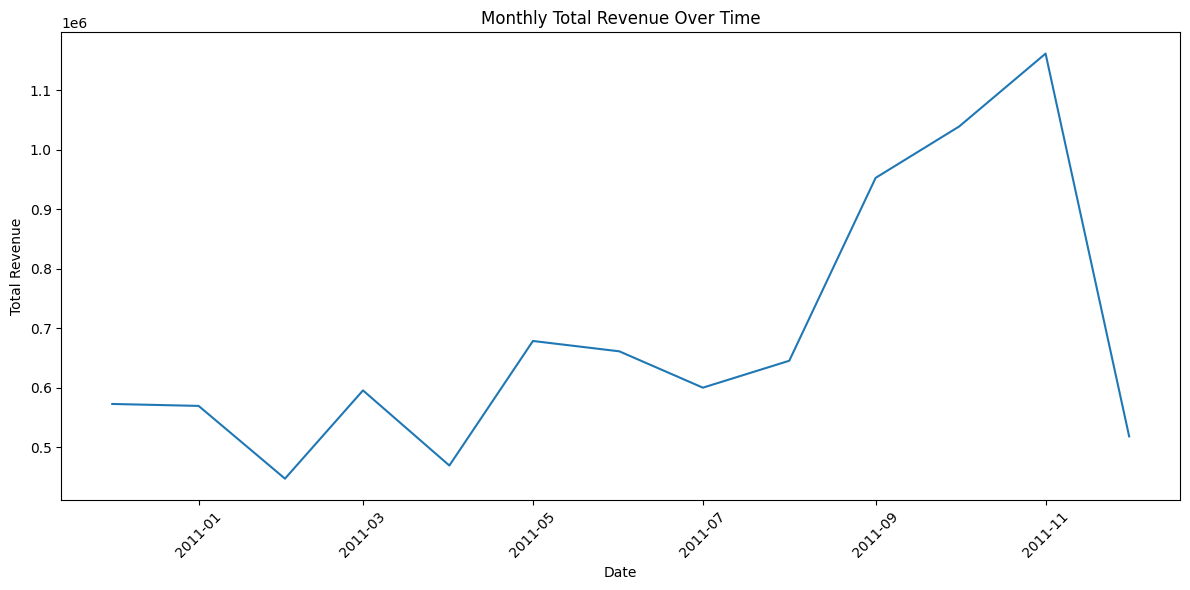

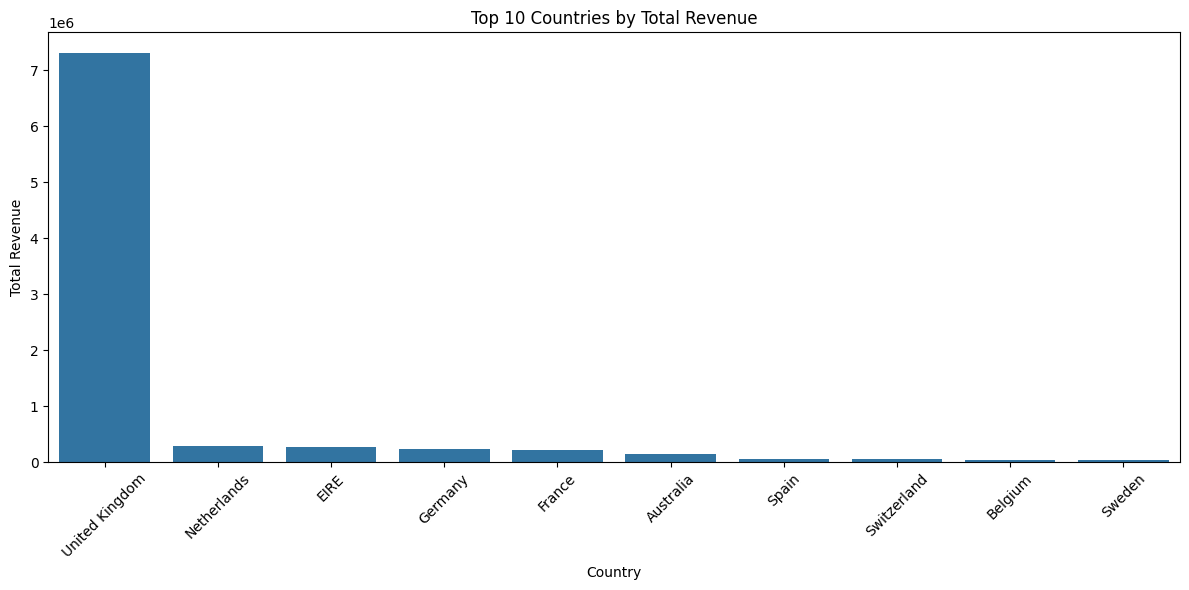

In [ ]:
from pyspark.sql.functions import sum as spark_sum
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate total revenue per month and year and collect into pandas
monthly_revenue = df_clean.groupBy("Year", "Month").agg(spark_sum("TotalPrice").alias("TotalRevenue")).orderBy("Year", "Month").collect()
monthly_revenue_pd = pd.DataFrame(monthly_revenue, columns=["Year", "Month", "TotalRevenue"])
monthly_revenue_pd["Date"] = pd.to_datetime(monthly_revenue_pd["Year"].astype(str) + "-" + monthly_revenue_pd["Month"].astype(str))

# 2. Plot time series of monthly total revenue
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_revenue_pd, x="Date", y="TotalRevenue")
plt.title("Monthly Total Revenue Over Time")
plt.xlabel("Date")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Calculate total revenue for each country and collect into pandas
country_revenue = df_clean.groupBy("Country").agg(spark_sum("TotalPrice").alias("TotalRevenue")).orderBy(col("TotalRevenue").desc()).collect()
country_revenue_pd = pd.DataFrame(country_revenue, columns=["Country", "TotalRevenue"])

# 4. Create a bar chart showing total revenue for top countries
plt.figure(figsize=(12, 6))
sns.barplot(data=country_revenue_pd.head(10), x="Country", y="TotalRevenue")
plt.title("Top 10 Countries by Total Revenue")
plt.xlabel("Country")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Reasoning**:
Calculate the total quantity sold for each product description, sort the results in descending order, collect into a pandas DataFrame, and plot a bar chart for the top products.



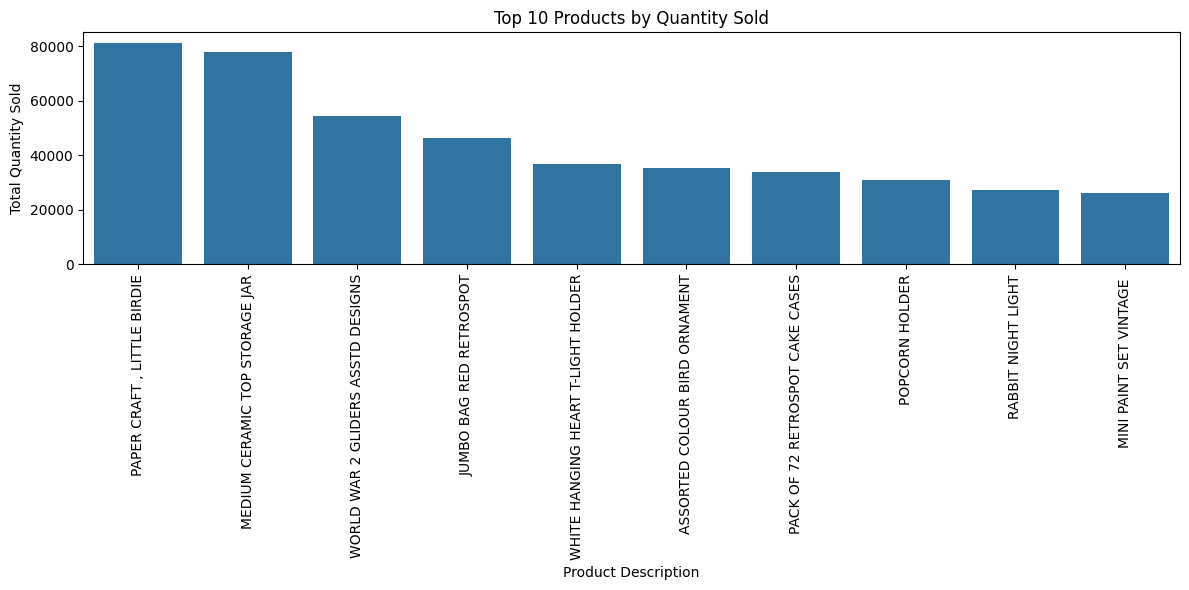

In [ ]:
# 5. Calculate total quantity sold for each product description and collect into pandas
product_quantity = df_clean.groupBy("Description").agg(spark_sum("Quantity").alias("TotalQuantity")).orderBy(col("TotalQuantity").desc()).collect()
product_quantity_pd = pd.DataFrame(product_quantity, columns=["Description", "TotalQuantity"])

# 6. Generate a bar chart displaying total quantity sold for top products
plt.figure(figsize=(12, 6))
sns.barplot(data=product_quantity_pd.head(10), x="Description", y="TotalQuantity")
plt.title("Top 10 Products by Quantity Sold")
plt.xlabel("Product Description")
plt.ylabel("Total Quantity Sold")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Reasoning: Calculate the average total price for each month and year, collect the results into a pandas DataFrame, and plot the time series.

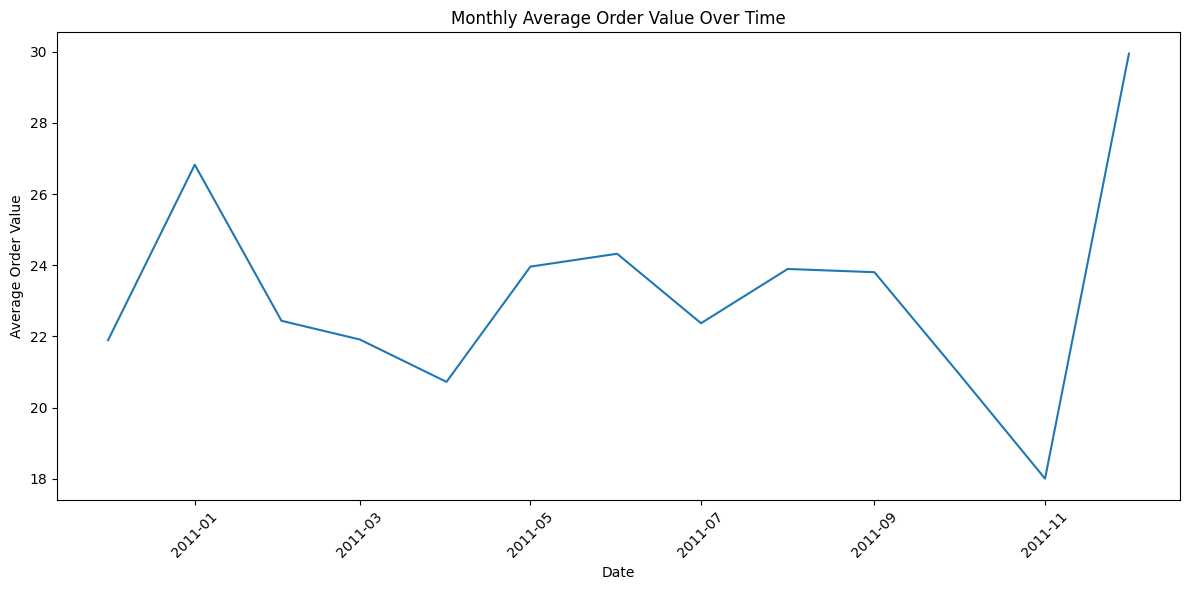

In [17]:
from pyspark.sql.functions import avg
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.sql.functions import col

# Calculate average total price per month and year and collect into pandas
monthly_avg_order_value = df_clean.groupBy("Year", "Month").agg(avg("TotalPrice").alias("AverageOrderValue")).orderBy("Year", "Month").collect()
monthly_avg_order_value_pd = pd.DataFrame(monthly_avg_order_value, columns=["Year", "Month", "AverageOrderValue"])
monthly_avg_order_value_pd["Date"] = pd.to_datetime(monthly_avg_order_value_pd["Year"].astype(str) + "-" + monthly_avg_order_value_pd["Month"].astype(str))

# Plot time series of monthly average order value
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_avg_order_value_pd, x="Date", y="AverageOrderValue")
plt.title("Monthly Average Order Value Over Time")
plt.xlabel("Date")
plt.ylabel("Average Order Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Perform in-depth analysis of returns

### Subtask:
Analyze the characteristics of returned items, such as the most frequently returned products and the reasons for returns if available in the data.


**Reasoning**:
Filter the original DataFrame to get returned items, group by description, sum the quantities, order by sum of quantity in ascending order, and show the top 10.



In [ ]:
from pyspark.sql.functions import col

df_raw = spark.read.csv("online_retail.csv", header=True, inferSchema=True)

df_returns = df_raw.filter(col("InvoiceNo").startswith("C"))
returned_item_quantities = df_returns.groupBy("Description")\
    .sum("Quantity")\
    .orderBy(col("sum(Quantity)").asc())

returned_item_quantities.show(10, truncate=False)

+-----------------------------------+-------------+
|Description                        |sum(Quantity)|
+-----------------------------------+-------------+
|PAPER CRAFT , LITTLE BIRDIE        |-80995       |
|MEDIUM CERAMIC TOP STORAGE JAR     |-74494       |
|ROTATING SILVER ANGELS T-LIGHT HLDR|-9376        |
|Manual                             |-4066        |
|FAIRY CAKE FLANNEL ASSORTED COLOUR |-3150        |
|PINK BLUE FELT CRAFT TRINKET BOX   |-2617        |
|WHITE HANGING HEART T-LIGHT HOLDER |-2578        |
|GIN + TONIC DIET METAL SIGN        |-2030        |
|HERB MARKER BASIL                  |-1527        |
|FELTCRAFT DOLL MOLLY               |-1447        |
+-----------------------------------+-------------+
only showing top 10 rows

